In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pprint

import numpy
import pandas
# import napari
import seaborn
import torch
from imageio import imread
from ruamel.yaml import YAML
from tqdm import tqdm
import matplotlib

from hylfm.eval.metrics import compute_metrics_individually, init_metrics
yaml = YAML(typ="safe")

/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/hylfm/_settings/default.py:76: UserWarning: numpy imported before hylfm. numpy env var settings won't take effect!
  warnings.warn("numpy imported before hylfm. numpy env var settings won't take effect!")


In [2]:
seaborn.set_style("darkgrid")
seaborn.set_context("notebook")  # paper, notebook, talk, poster

In [3]:
# root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/z_out49/growdynds_f4/20-11-02_11-41-23")
# zmod = 209
root = Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/test/heart/z_out49/contin_validate_f4/20-11-10_14-02-53")
zmod = 139
z_offset = 29

assert root.exists(), root
validation_step_dirs = sorted(root.glob("test_dynamic_*/run000"))

pprint([p.name for p in validation_step_dirs])

metrics_config = yaml.load(Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/configs/metrics/heart_dynamic.yml"))
metrics_instances = init_metrics(metrics_config)

['run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000',
 'run000']


In [4]:
# root = sorted(Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/logs/train/heart/z_out49/refine_f4/").glob("*"))[-1]
# print(root)
# config = yaml.load(root)
# zmod = 139
# validation_step_dirs = sorted(root.glob("validate_train_01/run*"))

# pprint([p.name for p in validation_step_dirs][-5:])

# metrics_config = yaml.load(Path("/g/kreshuk/beuttenm/pycharm_tmp/repos/hylfm-net/configs/metrics/heart_dynamic.yml"))
# metrics_instances = init_metrics(metrics_config)

In [60]:
# ls_slices = numpy.stack([imread(p) for p in sorted(validation_step_dirs[0].glob("ds0-0/ls_slice/*.tif"))])
# print(ls_slices.shape, flush=True)
all_preds = []
all_ls_slices = []
for step_dir in tqdm(validation_step_dirs):
    ls_slices = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/ls_slice/*.tif"))])
    assert (ls_slices.shape[0] % zmod) == 0
    all_ls_slices.append(ls_slices)
    preds = numpy.stack([imread(p) for p in sorted(step_dir.glob("ds0-0/pred/*.tif"))])
    assert preds.shape == ls_slices.shape, (preds.shape, ls_slices.shape)
    all_preds.append(preds)

100%|██████████| 39/39 [00:37<00:00,  1.03it/s]


In [61]:
data = None
for pred_nr, (preds, ls_slices) in enumerate(tqdm(zip(all_preds, all_ls_slices), total=len(all_preds))):
    for step, (pred, ls_slice) in enumerate(zip(preds, ls_slices)):
        # add batch and channel dim
        pred = pred[None, None]
        ls_slice = ls_slice[None, None]

        tensors = {"pred": torch.from_numpy(pred), "ls_slice": torch.from_numpy(ls_slice)}
        computed_metrics = {k: m.value for k, m in compute_metrics_individually(metrics_instances, tensors).items()}
        computed_metrics["step"] = step
        computed_metrics["pred_nr"] = pred_nr
        if data is None:
            data = {k: [v] for k, v in computed_metrics.items()}
        else:
            for mk, mv in computed_metrics.items():
                data[mk].append(mv)

39it [01:36,  2.47s/it]


In [62]:
df = pandas.DataFrame.from_dict(data)
df.tail()

smooth_l1_loss-scaled  ms_ssim-scaled  ssim-scaled  nrmse-scaled  \
5416               0.000246        0.857433     0.758668      0.997581   
5417               0.000241        0.874921     0.813605      0.999759   
5418               0.000222        0.885672     0.862738      0.995347   
5419               0.000113        0.917416     0.906039      0.993499   
5420               0.000043        0.952115     0.936382      0.993261   

      psnr-scaled  mse_loss-scaled  step  pred_nr  
5416    33.077483         0.000492   134       38  
5417    33.164353         0.000483   135       38  
5418    33.522811         0.000444   136       38  
5419    36.451325         0.000226   137       38  
5420    40.655084         0.000086   138       38

In [63]:
df["z"] = (df["step"] % zmod) + z_offset
df["frame"] = df["pred_nr"] * 241 + df["step"] + z_offset
df["time [s]"] = df["frame"] * 0.025
df.tail()

smooth_l1_loss-scaled  ms_ssim-scaled  ssim-scaled  nrmse-scaled  \
5416               0.000246        0.857433     0.758668      0.997581   
5417               0.000241        0.874921     0.813605      0.999759   
5418               0.000222        0.885672     0.862738      0.995347   
5419               0.000113        0.917416     0.906039      0.993499   
5420               0.000043        0.952115     0.936382      0.993261   

      psnr-scaled  mse_loss-scaled  step  pred_nr    z  frame  time [s]  
5416    33.077483         0.000492   134       38  163   9321   233.025  
5417    33.164353         0.000483   135       38  164   9322   233.050  
5418    33.522811         0.000444   136       38  165   9323   233.075  
5419    36.451325         0.000226   137       38  166   9324   233.100  
5420    40.655084         0.000086   138       38  167   9325   233.125

In [98]:
df["pred"] = df.apply(lambda row: all_preds[int(row.pred_nr)][int(row.step)], axis=1)
df["spim"] = df.apply(lambda row: all_ls_slices[int(row.pred_nr)][int(row.step)], axis=1)
df["spim_mean_intensity"] = df.spim.apply(lambda img: img.mean())
df["pred_mean_intensity"] = df.pred.apply(lambda img: img.mean())
df["spim_mean_intensity-pred_mean_intensity"] = df.spim_mean_intensity - df.pred_mean_intensity
df.tail()

smooth_l1_loss-scaled  ms_ssim-scaled  ssim-scaled  nrmse-scaled  \
5416               0.000246        0.857433     0.758668      0.997581   
5417               0.000241        0.874921     0.813605      0.999759   
5418               0.000222        0.885672     0.862738      0.995347   
5419               0.000113        0.917416     0.906039      0.993499   
5420               0.000043        0.952115     0.936382      0.993261   

      psnr-scaled  mse_loss-scaled  step  pred_nr    z  frame  time [s]  \
5416    33.077483         0.000492   134       38  163   9321   233.025   
5417    33.164353         0.000483   135       38  164   9322   233.050   
5418    33.522811         0.000444   136       38  165   9323   233.075   
5419    36.451325         0.000226   137       38  166   9324   233.100   
5420    40.655084         0.000086   138       38  167   9325   233.125   

                                                   pred  \
5416  [[0.0021547163, 0.0021547163, 0.0021547163, 0....   
5417  [[0.0025469975, 0.0025470369, 0.0025470767, 0....   
5418  [[0.0038770393, 0.0038770922, 0.0038771457, 0....   
5419  [[0.0033707616, 0.003370806, 0.00337085, 0.003...   
5420  [[0.0036222478, 0.003622293, 0.0036223384, 0.0...   

                                                   spim  spim mean intensity  \
5416  [[0.0018686597, 0.0018678564, 0.0024882997, 0....             0.007782   
5417  [[0.0024949498, 0.0019335785, 0.0018581687, 0....             0.007031   
5418  [[0.0018698672, 0.0018569423, 0.0018108143, 0....             0.006186   
5419  [[0.0025122243, 0.0024348083, 0.001775372, 0.0...             0.005238   
5420  [[0.0018773492, 0.0018583303, 0.0014894195, 0....             0.004403   

      pred mean intensity                                mean intensity diff  \
5416             0.005011  [[-0.00028605654, -0.00028685993, 0.0003335834...   
5417             0.004656  [[-5.204766e-05, -0.00061345834, -0.0006889079...   
5418             0.004281  [[-0.002007172, -0.00202015, -0.0020663314, -0...   
5419             0.004286  [[-0.0008585374, -0.0009359978, -0.0015954782,...   
5420             0.004247  [[-0.0017448986, -0.0017639627, -0.002132919, ...   

      spim_mean_intensity  pred_mean_intensity  mean_intensity_diff  \
5416             0.007782             0.005011             0.002771   
5417             0.007031             0.004656             0.002375   
5418             0.006186             0.004281             0.001905   
5419             0.005238             0.004286             0.000952   
5420             0.004403             0.004247             0.000156   

      spim_mean_intensity-pred_mean_intensity  
5416                                 0.002771  
5417                                 0.002375  
5418                                 0.001905  
5419                                 0.000952  
5420                                 0.000156

In [115]:
# small_df = pandas.concat([df[:10], df[135:140]])
# small_df
df["spim_mean_intensity_pred_nr"] = df.groupby("pred_nr").spim_mean_intensity.apply(numpy.mean)
df["spim_mean_intensity_pred_nr_max"] = df.groupby("pred_nr").spim_mean_intensity.apply(numpy.max)

In [107]:
df_filtered = df
# df_filtered = df[df.z == 150]
# df_filtered = df[df.scan < 2500]
df_filtered.tail()

smooth_l1_loss-scaled  ms_ssim-scaled  ssim-scaled  nrmse-scaled  \
5416               0.000246        0.857433     0.758668      0.997581   
5417               0.000241        0.874921     0.813605      0.999759   
5418               0.000222        0.885672     0.862738      0.995347   
5419               0.000113        0.917416     0.906039      0.993499   
5420               0.000043        0.952115     0.936382      0.993261   

      psnr-scaled  mse_loss-scaled  step  pred_nr    z  frame  time [s]  \
5416    33.077483         0.000492   134       38  163   9321   233.025   
5417    33.164353         0.000483   135       38  164   9322   233.050   
5418    33.522811         0.000444   136       38  165   9323   233.075   
5419    36.451325         0.000226   137       38  166   9324   233.100   
5420    40.655084         0.000086   138       38  167   9325   233.125   

                                                   pred  \
5416  [[0.0021547163, 0.0021547163, 0.0021547163, 0....   
5417  [[0.0025469975, 0.0025470369, 0.0025470767, 0....   
5418  [[0.0038770393, 0.0038770922, 0.0038771457, 0....   
5419  [[0.0033707616, 0.003370806, 0.00337085, 0.003...   
5420  [[0.0036222478, 0.003622293, 0.0036223384, 0.0...   

                                                   spim  spim mean intensity  \
5416  [[0.0018686597, 0.0018678564, 0.0024882997, 0....             0.007782   
5417  [[0.0024949498, 0.0019335785, 0.0018581687, 0....             0.007031   
5418  [[0.0018698672, 0.0018569423, 0.0018108143, 0....             0.006186   
5419  [[0.0025122243, 0.0024348083, 0.001775372, 0.0...             0.005238   
5420  [[0.0018773492, 0.0018583303, 0.0014894195, 0....             0.004403   

      pred mean intensity                                mean intensity diff  \
5416             0.005011  [[-0.00028605654, -0.00028685993, 0.0003335834...   
5417             0.004656  [[-5.204766e-05, -0.00061345834, -0.0006889079...   
5418             0.004281  [[-0.002007172, -0.00202015, -0.0020663314, -0...   
5419             0.004286  [[-0.0008585374, -0.0009359978, -0.0015954782,...   
5420             0.004247  [[-0.0017448986, -0.0017639627, -0.002132919, ...   

      spim_mean_intensity  pred_mean_intensity  mean_intensity_diff  \
5416             0.007782             0.005011             0.002771   
5417             0.007031             0.004656             0.002375   
5418             0.006186             0.004281             0.001905   
5419             0.005238             0.004286             0.000952   
5420             0.004403             0.004247             0.000156   

      spim_mean_intensity-pred_mean_intensity  
5416                                 0.002771  
5417                                 0.002375  
5418                                 0.001905  
5419                                 0.000952  
5420                                 0.000156

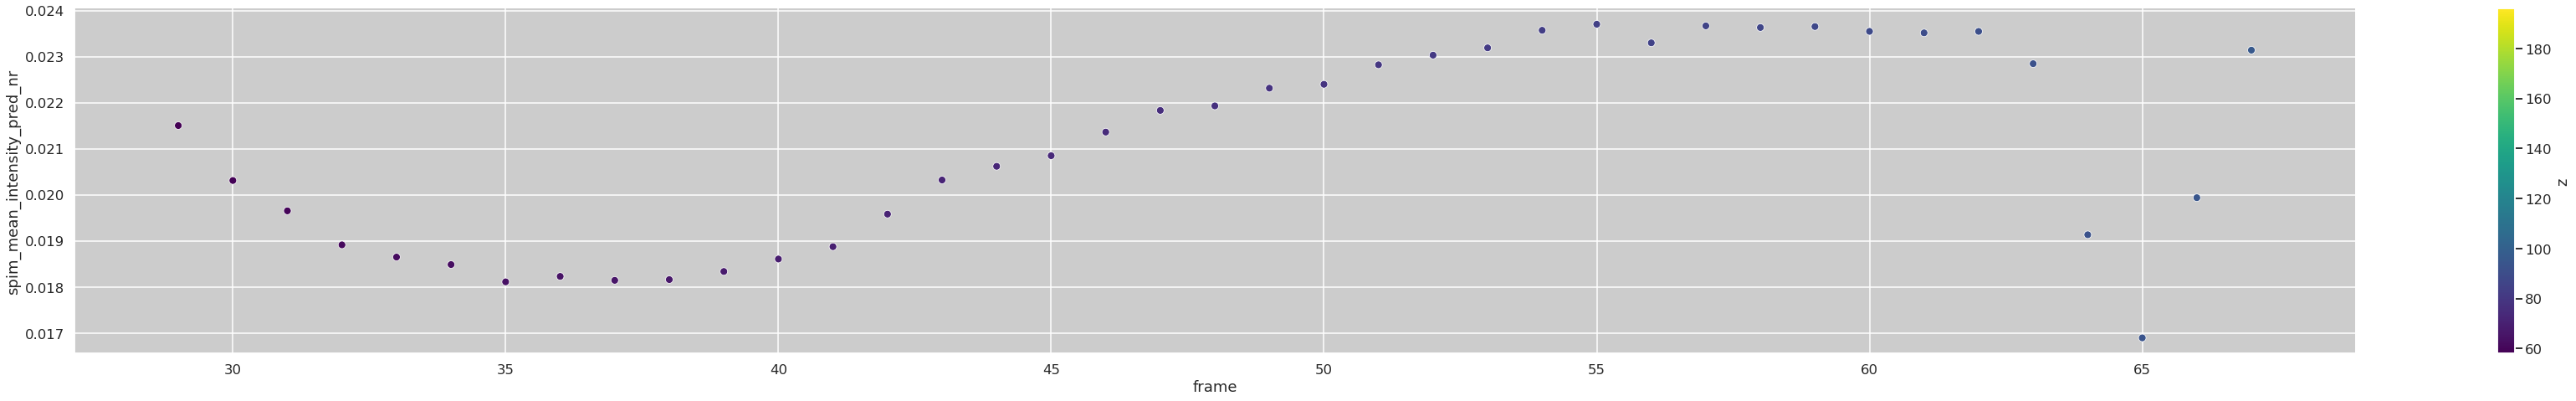

In [128]:
cmap_name = "viridis"
y_name = "spim_mean_intensity_pred_nr"
g = seaborn.relplot(x="frame", y=y_name, hue="z", legend=False,
                    palette=cmap_name, height=7, aspect=7,
                    kind="scatter", data=df_filtered)
g.fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=df_filtered["z"].min()+z_offset, vmax=df_filtered["z"].max()+z_offset, clip=False), cmap=cmap_name), label='z')
g.fig.savefig(f"continous_validation_plots/{y_name}.png")

In [122]:
df.at[1, "frame"]

30

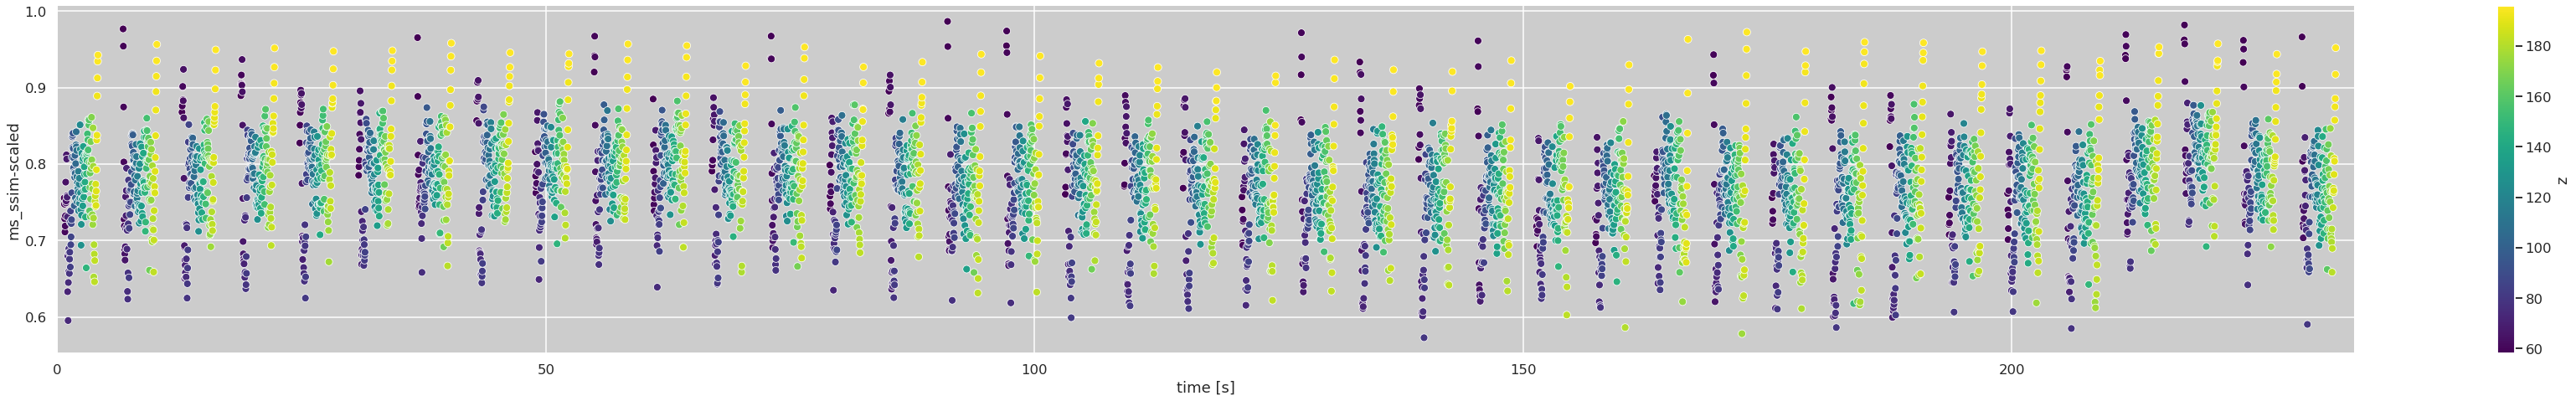

In [67]:
def plot_scans(metric: str):
    seaborn.set_style("darkgrid", {"axes.facecolor": ".8"})
    seaborn.set_context("talk")  # paper, notebook, talk, poster
    cmap_name = "viridis"
    g = seaborn.relplot(x="time [s]", y=metric, hue="z", legend=False,
                    palette=cmap_name, height=7, aspect=7,
                    kind="scatter", data=df_filtered)
    g.fig.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=df_filtered["z"].min()+z_offset, vmax=df_filtered["z"].max()+z_offset, clip=False), cmap=cmap_name), label='z')
#     g.fig.axes[0].set_xlim(0, 9399)
    g.fig.axes[0].set_xlim(0, 9399*0.025)
    g.fig.tight_layout()
    root = Path("continous_validation_plots")
    root.mkdir(exist_ok=True)
    g.fig.savefig(root / f"{metric}.png")

plot_scans("ms_ssim-scaled")

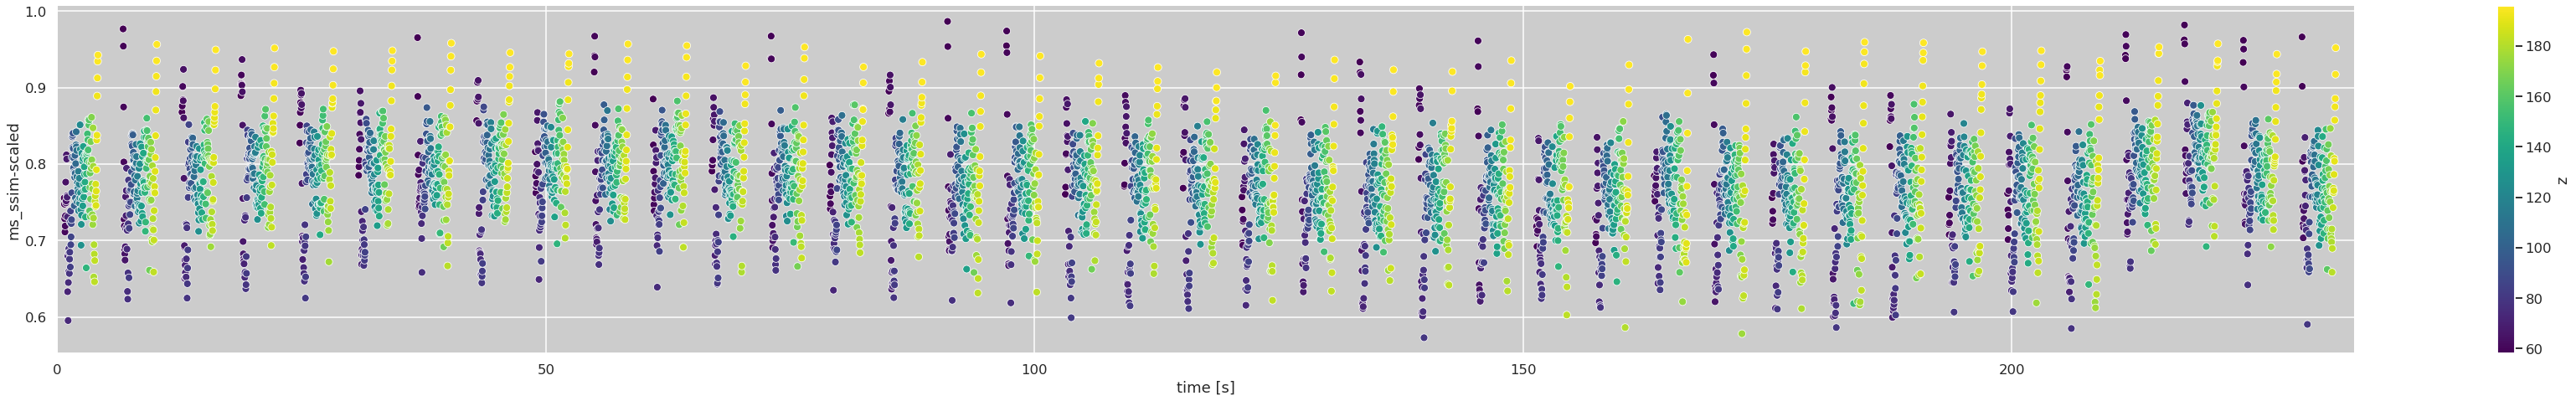

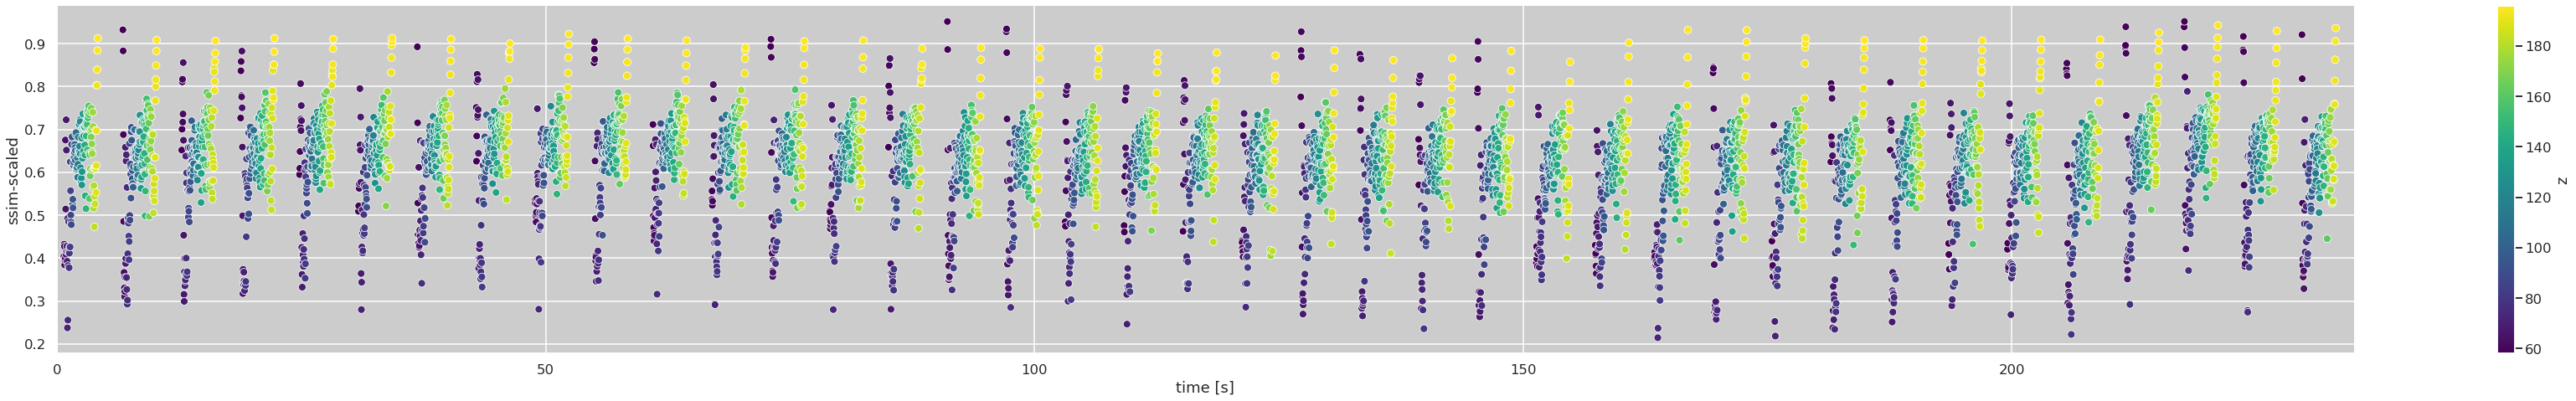

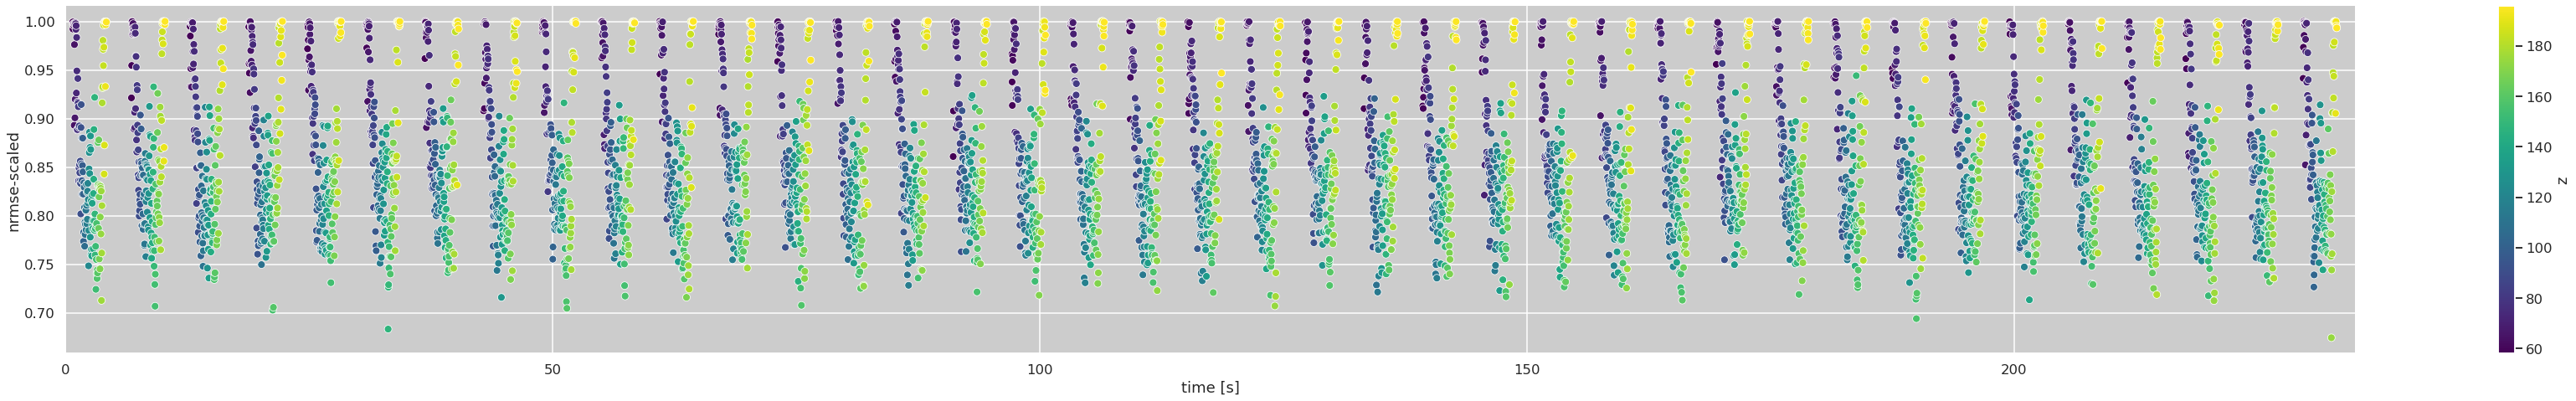

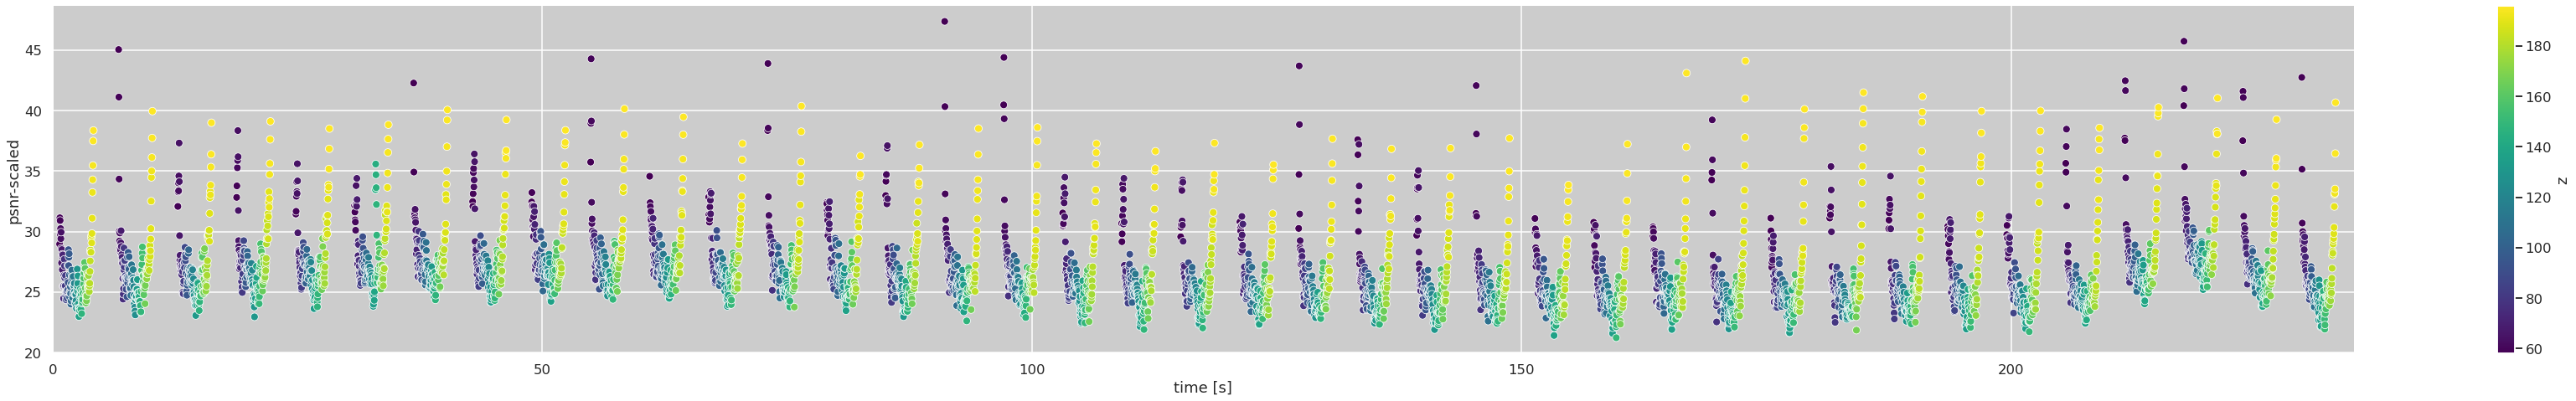

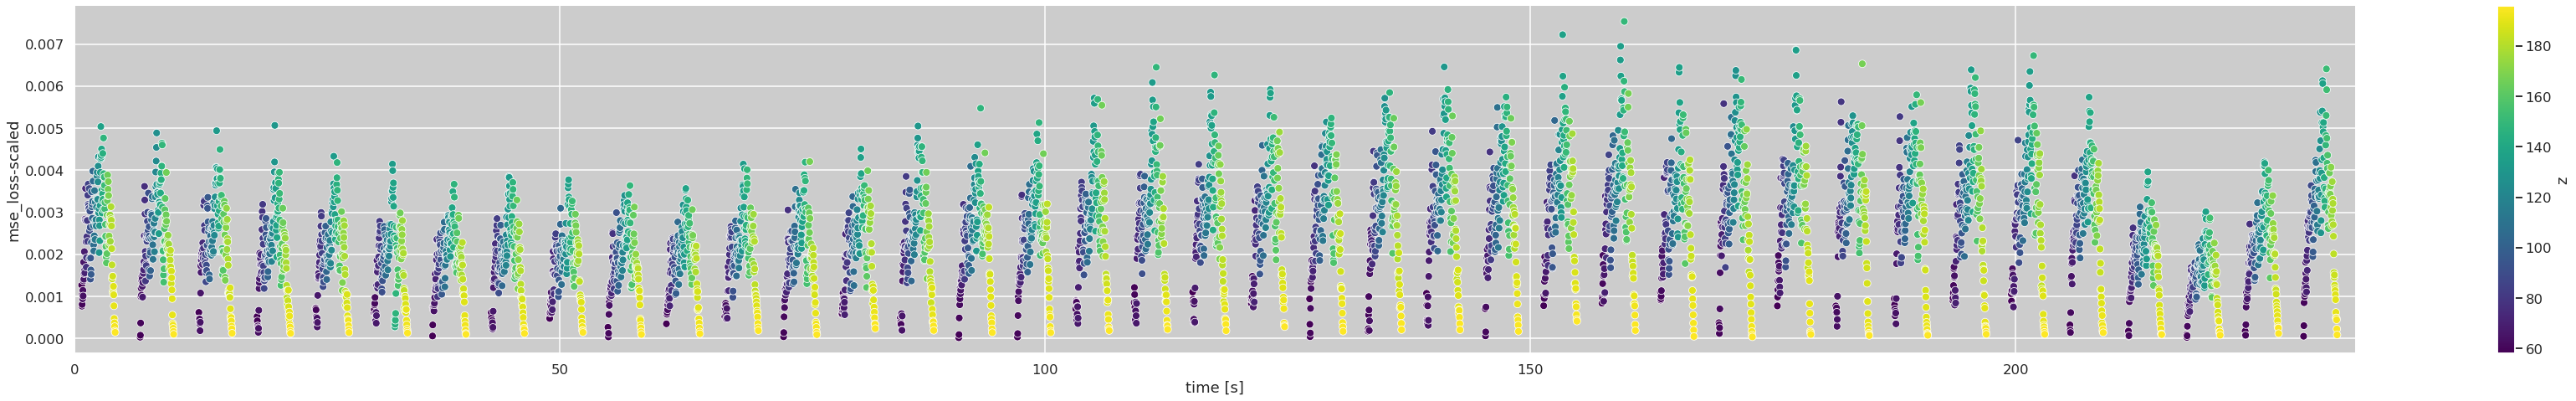

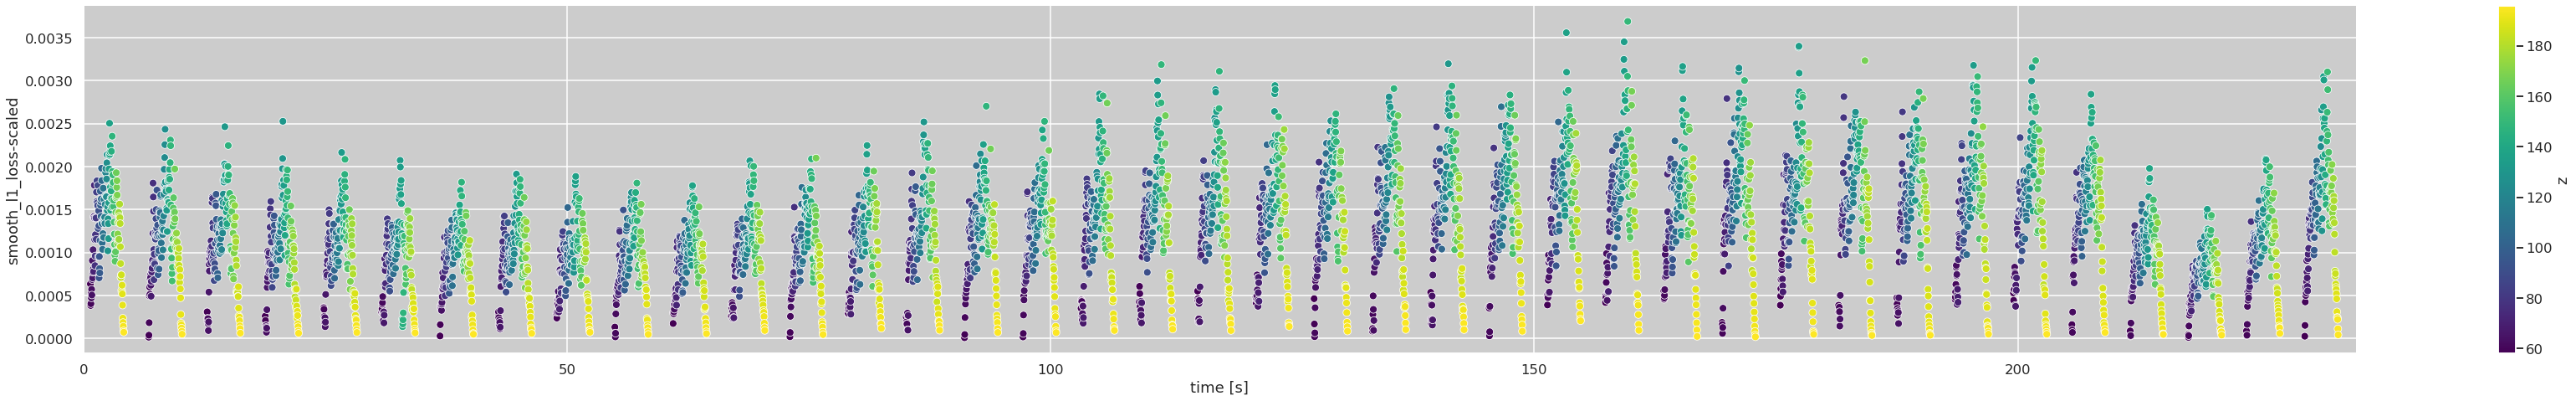

In [124]:
plot_scans("ms_ssim-scaled")
plot_scans("ssim-scaled")
plot_scans("nrmse-scaled")
plot_scans("psnr-scaled")
plot_scans("mse_loss-scaled")
plot_scans("smooth_l1_loss-scaled")